<a href="https://colab.research.google.com/github/JongeunKeum/doit-deeplearning/blob/main/4%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [2]:
print(cancer.data.shape, cancer.target.shape)

(569, 30) (569,)


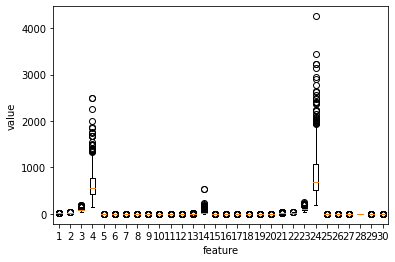

In [3]:
import matplotlib.pyplot as plt
plt.boxplot(cancer.data)
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [4]:
import numpy as np
np.unique(cancer.target, return_counts=True)
# 이진분류니까 target은 0 or 1
# return_counts는 각 값 개수 -> 여기선 양성클래스가 더 많음. 편중된 데이터

(array([0, 1]), array([212, 357]))

In [5]:
x = cancer.data
y = cancer.target

### 훈련 세트와 테스트 세트 나누기

# 로지스틱 회귀로 모델 만들기

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [8]:
print(x_train.shape, x_test.shape)

(455, 30) (114, 30)


In [9]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([170, 285]))

In [10]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([42, 72]))

In [11]:
class LogisticNeuron:

  def __init__(self):
    self.w = None
    self.b = None

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b   # 직선 방정식 계산, x*self.w -> 벡터 각 위치값끼리 곱
    return z

  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1])      # 가중치 초기화, x 열의 개수만큼 1로 초기화
    self.b = 0                        # 절편 초기화
    for i in range(epochs):           # epochs만큼 반복
      for x_i, y_i in zip(x, y):      # 모든 샘플에 대해 반복
        z = self.forpass(x_i)         # 정방향 계산
        a = self.activation(z)        # 활성화 함수 적용(시그모이드)
        err = -(y_i - a)              # 오차 계산
        w_grad, b_grad = self.backprop(x_i, err)    # 역방향 계산
        self.w -= w_grad              # 가중치 업데이트
        self.b -= b_grad              # 절편 업데이트
  
  def activation(self, z):
    a = 1 / (1 + np.exp(-z))      # 시그모이드 계산
    return a

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]    # 선형 함수 적용
    a = self.activation(np.array(z))        # 활성화 함수 적용
    return a > 0.5                          # 계단 함수 적용

In [12]:
neuron = LogisticNeuron()
neuron.fit(x_train, y_train)

<ipython-input-11-0bd60d22ba43>:29: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-z))      # 시그모이드 계산


In [13]:
np.mean(neuron.predict(x_test) == y_test)

<ipython-input-11-0bd60d22ba43>:29: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-z))      # 시그모이드 계산


0.8245614035087719

# 단일층 신경망 만들기

In [14]:
class SingleLayer:

  def __init__(self):
    self.w = None
    self.b = None
    self.losses = []    # 손실값을 저장하는 리스트

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b   # 직선 방정식 계산
    return z

  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):
    z = np.clip(z, -100, None)    # 안전한 np.exp() 계산을 위해
    a = 1 / (1 + np.exp(-z))      # 시그모이드 계산
    return a

  def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1])
    self.b = 0
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x)))    # 인덱스 섞기
      for i in indexes:                       # 모든 샘플에 대해 반복
        z = self.forpass(x[i])                # 정방향 계산
        a = self.activation(z)                # 활성화 함수 적용
        err = -(y[i] - a)                     # 오차 계산
        w_grad, b_grad = self.backprop(x[i], err)   # 역방향 계산
        self.w -= w_grad                      # 가중치 업데이트
        self.b -= b_grad                      # 절편 업데이트
        a = np.clip(a, 1e-10, 1-1e-10)        # 안전한 로그 계산을 위해 클리핑을 한 후 손실 누적
        loss += -(y[i] * np.log(a) + (1 - y[i]) * np.log(1-a))
      self.losses.append(loss/len(y))         # 에포크마다 평균 손실 저장

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]    # 정방향 계산
    return np.array(z) > 0                  # 스텝 함수 적용

  def score(self, x, y):
    return np.mean(self.predict(x) == y)

In [15]:
layer = SingleLayer()
layer.fit(x_train, y_train)
layer.score(x_test, y_test)

0.9298245614035088

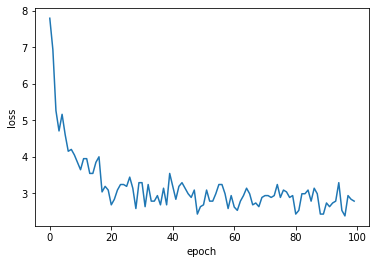

In [16]:
plt.plot(layer.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 사이킷런으로 로지스틱 회귀 수행

In [18]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', max_iter=100, tol=1e-3, random_state=42)

In [19]:
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


0.8333333333333334

In [20]:
sgd.predict(x_test[0:10])

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])